# Corona in Hamburg

In [1]:
import datetime
import json
import os
import re
import urllib.parse

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
CORONA_DATA_URL = "https://www.hamburg.de/corona-zahlen/"
MONTHS = ["Januar", "Februar", "März", "April", "Mai", "Juni",
          "Juli", "August", "September", "Oktober", "November", "Dezember"]
WEEKDAYS = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
BOROUGHS = {
    "Altona": 275265,
    "Bergedorf": 130260,
    "Eimsbüttel": 267053,
    "Hamburg Mitte": 301546,
    "Hamburg Nord": 314595,
    "Harburg": 169426,
    "Wandsbek": 441015,
    "Hamburg": 1899160,
}

In [3]:
RESTRICTIONS = {
    datetime.date(2020, 2, 29): ("", "w"),
    datetime.date(2020, 3, 16): ("schools closed", "y"),
    datetime.date(2020, 3, 23): ("lockdown", "r"),
    datetime.date(2020, 4, 20): ("", "y"),
    datetime.date(2020, 4, 27): ("masks required", "g"),
    datetime.date(2020, 10, 12): ("masks required in more areas", "b"),
    datetime.date(2020, 10, 26): ("contact restrictions", "y"),
    datetime.date(2020, 11, 2): ("lockdown \"light\"", "m"),
    datetime.date(2020, 12, 16): ("lockdown", "r")
}

In [4]:
r = requests.get(CORONA_DATA_URL)
if r.ok:
    soup = bs4.BeautifulSoup(r.text)
    historic_case_data_header = soup.find("h2", text="Inzidenz zum Download")
    if historic_case_data_header:
        df = pd.read_excel(
            urllib.parse.urljoin(
                CORONA_DATA_URL,
                historic_case_data_header.parent.find_next("div").a["href"]
            ),
            index_col=1,
            skiprows=[0],
            parse_dates=True
        )
        daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
        df = df.drop(
            set(df.columns) - {"Datum", "Gesamthaft gemeldete SARS-CoV-2 Infektionen"},
            axis="columns"
        ).rename(columns={
            "Datum": "date",
            "Gesamthaft gemeldete SARS-CoV-2 Infektionen": "cases"
        })

        try:
            date = pd.DateOffset(days=-1).apply(df.index[0])
            df.loc[date] = daily_cases.cumsum().loc[date]
            df = df.dropna().sort_index().diff().dropna().astype(int)

            daily_cases.update(df)
            daily_cases.astype(int).to_csv("corona-hamburg-daily.csv")
        
        except Exception as e:
            pass

    header = soup.find("h2", text="Neue Fälle: Sieben Tage Chart")
    if not header:
        header = soup.find("h2", text="Neue Fälle: Sieben Tage Inzidenz")

    if header:
        values = [el.text.strip() for el in soup.find_all(attrs={"class": "value_show"})]
        par = soup.find(lambda el: el.name == "p" and el.text.strip().startswith("Bei der Inzidenz"))
        if values and par:
            date = datetime.datetime.strptime(par.find_all("strong")[1].text[1:-1], "%d.%m.%Y").date()
            dates = reversed([(date - datetime.timedelta(days=d)).isoformat() for d in range(7)])

            with open("corona-hamburg-daily.csv", "r+") as f:
                lines = [line.strip() for line in f]
                for line in [f"{d},{val}" for d, val in zip(dates, values)]:
                    if line not in lines:
                        f.write(f"{line}\n")

    header = soup.find("h3", text="Entwicklung der Zahl der positiv auf COVID-19 getesteten Personen nach Bezirken")
    if header:
        table = header.parent.find("table")
        timestamp = table.parent.parent.find_all("p")[-1].text.replace("Stand:", "")
        timestamp = re.sub(r"[.,]+", " ", timestamp).split()
        timestamp = f"{timestamp[2]}-{MONTHS.index(timestamp[1])+1:0>2}-{int(timestamp[0]):0>2}"
        total_cases = [timestamp]
        for row in table.find_all("tr"):
            borough = row.find(attrs={"data-label": "Bezirk"})
            if not borough:
                continue
            cases = row.find(attrs={"data-label": "Fallzahlen"})
            if cases:
                total_cases.append(cases.text.strip())

        with open("corona-hamburg.csv", "r+") as f:
            lines = [line.strip() for line in f]
            total_cases_line = ",".join(total_cases)
            if total_cases_line not in lines and len(total_cases) > 2 and not any(timestamp in l for l in lines):
                f.write(f"{total_cases_line}\n")

In [5]:
r = requests.get("https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_Hamburg")
if r.ok:
    soup = bs4.BeautifulSoup(r.text)
    data = json.loads(re.findall(r"RLCONF=(.*?);", soup.script.string, re.DOTALL)[0].replace("!0", "true").replace("!1", "false"))
    graph_id = soup.find_all(attrs={"class": "mw-graph"})[3]["data-graph-id"]
    df = pd.DataFrame([[datetime.datetime.strptime(e["x"], "%Y/%m/%d").date(), e["y"]] for e in data["wgGraphSpecs"][graph_id]["data"][0]["values"]], columns=["date", "deaths"]).set_index("date").astype(int)
    df.to_csv("corona-hamburg-deaths.csv")

In [6]:
daily_cases = pd.read_csv("corona-hamburg-daily.csv", index_col=0, parse_dates=True)
daily_cases_rolling7 = daily_cases.rolling(7).sum().dropna()

In [7]:
total_cases = pd.read_csv("corona-hamburg.csv", index_col=0, parse_dates=True)
new_cases = total_cases.diff().dropna().astype(int)

In [8]:
total_deaths = pd.read_csv("corona-hamburg-deaths.csv", index_col=0, parse_dates=True)

In [9]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Total Cases

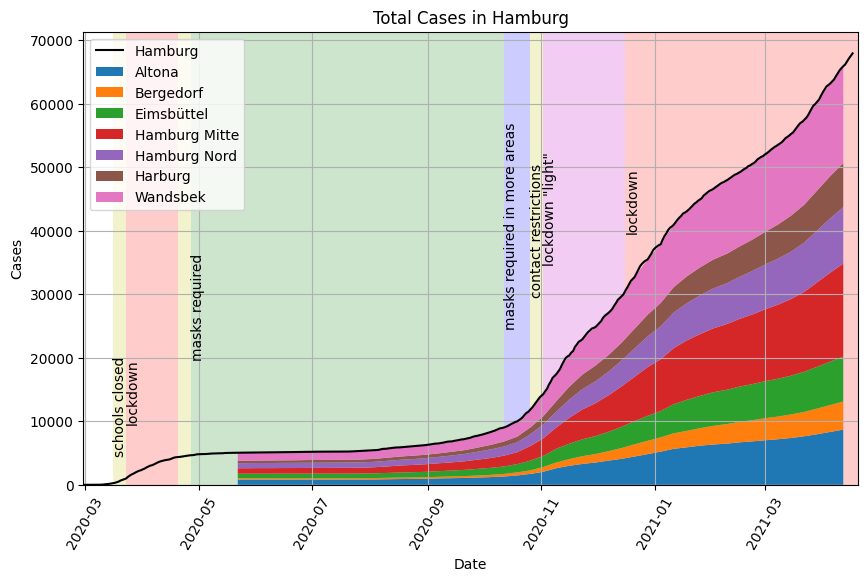

In [10]:
plt.figure()
plt.title("Total Cases in Hamburg")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.stackplot(total_cases.index, *total_cases.values.T, labels=total_cases.columns)
plt.plot(daily_cases.index, daily_cases.cumsum().values, "black", label="Hamburg")
y = 0
dy = 5000 # (daily_cases.cumsum().values.max() - 5000) / (len(RESTRICTIONS) - 1)
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
    plt.annotate(text, (date, y), rotation=90)
    y += dy
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

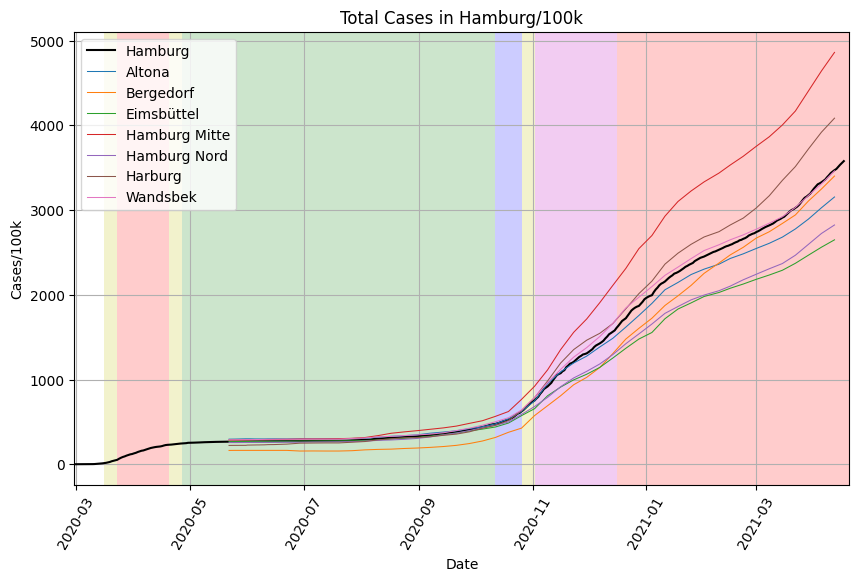

In [11]:
plt.figure()
plt.title("Total Cases in Hamburg/100k")
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.plot(daily_cases.index, daily_cases.cumsum().values / BOROUGHS["Hamburg"] * 1e5, "black", label="Hamburg")
for borough in new_cases.columns:
    plt.plot(total_cases.index, total_cases[borough] / BOROUGHS[borough] * 1e5, label=borough, lw=0.75)
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.legend(loc="upper left")
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

In [12]:
total_cases["Hamburg"] = total_cases.sum("columns")
total_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2021-02-09,6500,3094,5414,10364,6444,4651,11425,47892
2021-02-15,6685,3218,5547,10649,6613,4784,11682,49178
2021-02-22,6836,3335,5680,10961,6849,4922,11939,50522
2021-03-01,7011,3477,5829,11317,7055,5125,12235,52049
2021-03-08,7179,3575,5965,11657,7259,5370,12550,53555
2021-03-15,7379,3702,6114,12074,7452,5676,12878,55275
2021-03-22,7645,3833,6334,12572,7761,5953,13364,57462
2021-03-29,7965,4047,6590,13285,8165,6305,13993,60350
2021-04-05,8334,4232,6842,13999,8570,6641,14598,63216


In [13]:
daily_cases.cumsum().tail(8).T

date,2021-04-10,2021-04-11,2021-04-12,2021-04-13,2021-04-14,2021-04-15,2021-04-16,2021-04-17
cases,65277,65617,65926,66195,66674,67132,67552,67954


## New Cases

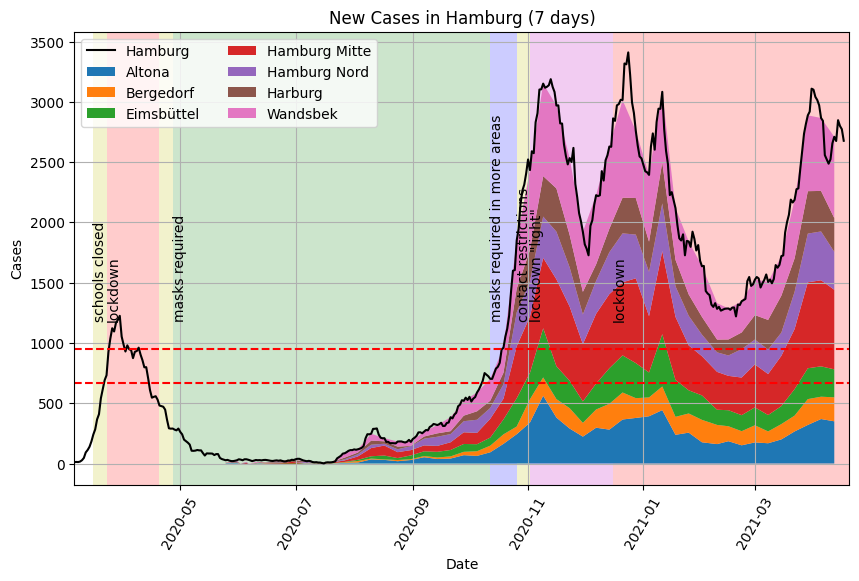

In [14]:
plt.figure()
plt.title("New Cases in Hamburg (7 days)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.stackplot(new_cases.index, *new_cases.values.T, labels=new_cases.columns)
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values, "black", label="Hamburg")
plt.axhline(y=950, c="r", ls="dashed")
plt.axhline(y=665, c="r", ls="dashed")
xmax = daily_cases_rolling7.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
    plt.annotate(text, (date, 1200), rotation=90)
plt.legend(loc="upper left", ncol=2)
plt.xlim(xmin=daily_cases_rolling7.index[0], xmax=xmax)
plt.xticks(rotation=60)
plt.grid()
plt.show()

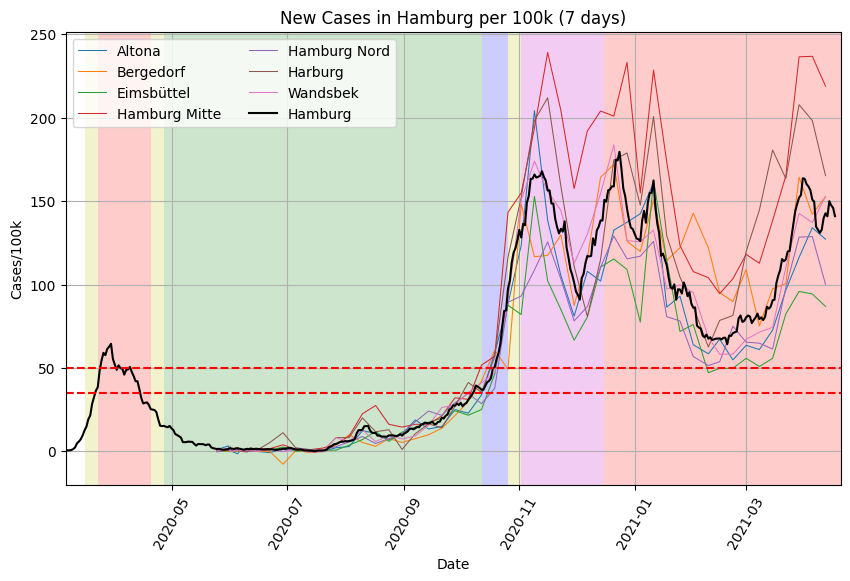

In [15]:
plt.figure()
for borough in new_cases.columns:
    plt.plot(new_cases.index, new_cases[borough] / BOROUGHS[borough] * 1e5, label=borough, lw=0.75)
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7.values / BOROUGHS["Hamburg"] * 1e5, "k-", label="Hamburg")
plt.axhline(y=50, c="r", ls="--")
plt.axhline(y=35, c="r", ls="--")
xmax = daily_cases_rolling7.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.title("New Cases in Hamburg per 100k (7 days)")
plt.legend(loc="upper left", ncol=2)
plt.xlabel("Date")
plt.ylabel("Cases/100k")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases_rolling7.index[0], xmax=xmax)
plt.grid()
plt.show()

In [16]:
new_cases["Hamburg"] = new_cases.sum("columns")
new_cases.tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2021-02-09,161,159,126,314,162,106,302,1330
2021-02-15,185,124,133,285,169,133,257,1286
2021-02-22,151,117,133,312,236,138,257,1344
2021-03-01,175,142,149,356,206,203,296,1527
2021-03-08,168,98,136,340,204,245,315,1506
2021-03-15,200,127,149,417,193,306,328,1720
2021-03-22,266,131,220,498,309,277,486,2187
2021-03-29,320,214,256,713,404,352,629,2888
2021-04-05,369,185,252,714,405,336,605,2866


In [17]:
(new_cases / pd.DataFrame(BOROUGHS, index=new_cases.index) * 1e5).round(2).tail(10)

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,Hamburg
date,,,,,,,,
2021-02-09,58.49,122.06,47.18,104.13,51.49,62.56,68.48,70.03
2021-02-15,67.21,95.19,49.80,94.51,53.72,78.50,58.27,67.71
2021-02-22,54.86,89.82,49.80,103.47,75.02,81.45,58.27,70.77
2021-03-01,63.58,109.01,55.79,118.06,65.48,119.82,67.12,80.40
2021-03-08,61.03,75.23,50.93,112.75,64.85,144.61,71.43,79.30
2021-03-15,72.66,97.50,55.79,138.29,61.35,180.61,74.37,90.57
2021-03-22,96.63,100.57,82.38,165.15,98.22,163.49,110.20,115.16
2021-03-29,116.25,164.29,95.86,236.45,128.42,207.76,142.63,152.07
2021-04-05,134.05,142.02,94.36,236.78,128.74,198.32,137.18,150.91


In [18]:
daily_cases_rolling7.tail(8).T

date,2021-04-10,2021-04-11,2021-04-12,2021-04-13,2021-04-14,2021-04-15,2021-04-16,2021-04-17
cases,2524.0,2656.0,2710.0,2675.0,2848.0,2800.0,2773.0,2677.0


In [19]:
df = (daily_cases_rolling7 / BOROUGHS["Hamburg"] * 1e5).round(2)
df["weekday"] = df.index.day_name()
df["week"] = df.index.isocalendar().week
df["year"] = [i.year - 1 if i.week == 53 and i.month == 1 else i.year for i in df.index]
df.pivot(index=("year", "week"), columns=["weekday"])["cases"][WEEKDAYS].loc[(2021, 1):]

weekday    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
year week                                                                
2021 1     126.06   138.43     144.17    137.06  149.12    154.96  154.91
     2     162.33   146.17     136.53    130.79  117.21    118.53  115.10
     3     111.52   104.20      98.36     97.41  100.10     90.93   97.20
     4      96.99    94.62     101.26     98.10   93.04     95.41   88.57
     5      86.14    86.30      75.35     74.24   73.56     69.40   68.40
     6      70.03    67.56      68.40     66.77   67.13     67.56   67.66
     7      67.71    67.13      68.08     68.14   64.24     69.45   69.19
     8      70.87    71.40      71.87     79.67   81.46     77.56   78.25
     9      80.30    81.46      80.83     76.88   78.72     80.25   82.56
     10     79.30    80.35      78.72     80.56   86.67     85.51   86.78
     11     90.57    90.88     100.89    105.42  108.63    115.26  114.00
     12    115.16   119.79     120.16    128.58  136.11    144.06  148.38
     13    152.07   153.70     163.70    163.28  160.12    158.75  156.44
     14    150.91   149.65     134.69    132.85  130.95    132.90  139.85
     15    142.69   140.85     149.96    147.43  146.01    140.96     NaN

## Daily Cases

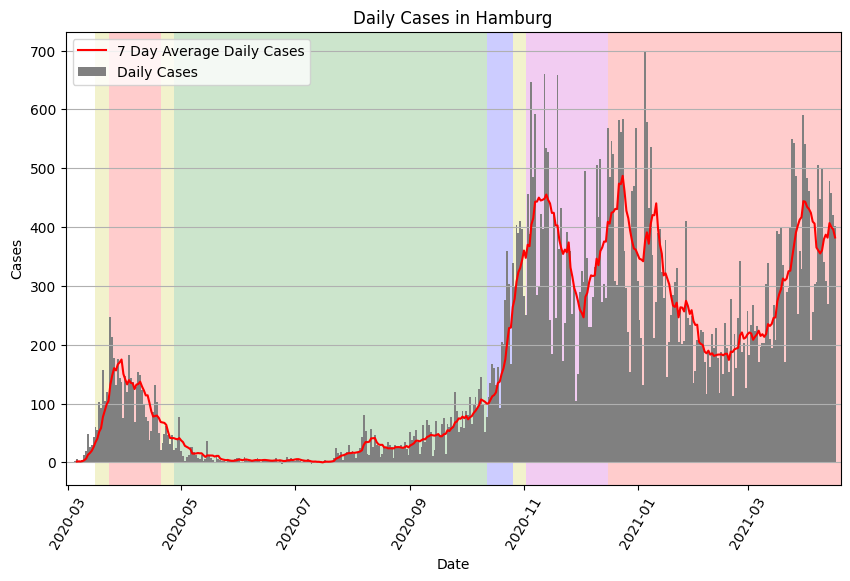

In [20]:
plt.figure()
plt.bar(daily_cases.index, daily_cases.values.T[0], width=1, color="grey", label="Daily Cases")
plt.plot(daily_cases_rolling7.index, daily_cases_rolling7 / 7, "red", label="7 Day Average Daily Cases")
xmax = daily_cases.index[-1] + datetime.timedelta(days=3)
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else xmax, facecolor=color, alpha=0.2, zorder=-1)
plt.title("Daily Cases in Hamburg")
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=60)
plt.xlim(xmin=daily_cases.index[0], xmax=xmax)
plt.grid(axis="y")
plt.show()

In [21]:
df = daily_cases.copy()
df["weekday"] = df.index.day_name()
df["week"] = df.index.isocalendar().week
df["year"] = [i.year - 1 if i.week == 53 and i.month == 1 else i.year for i in df.index]
df = df.pivot(index=("year", "week"), columns=["weekday"])["cases"][WEEKDAYS]
df["mean"] = df.mean(axis=1).round(2)
df.loc[(2021, 1):]

weekday    Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  \
year week                                                                   
2021 1      132.0    697.0      579.0     433.0   537.0     353.0   211.0   
     2      273.0    390.0      396.0     324.0   279.0     378.0   146.0   
     3      205.0    251.0      285.0     306.0   330.0     204.0   265.0   
     4      201.0    206.0      411.0     246.0   234.0     249.0   135.0   
     5      155.0    209.0      203.0     225.0   221.0     170.0   116.0   
     6      186.0    162.0      219.0     194.0   228.0     178.0   118.0   
     7      187.0    151.0      237.0     195.0   154.0     277.0   113.0   
     8      219.0    161.0      246.0     343.0   188.0     203.0   126.0   
     9      258.0    183.0      234.0     268.0   223.0     232.0   170.0   
     10     196.0    203.0      203.0     303.0   339.0     210.0   194.0   
     11     268.0    209.0      393.0     389.0   400.0     336.0   170.0   
     12     290.0    297.0      400.0     549.0   543.0     487.0   252.0   
     13     360.0    328.0      590.0     541.0   483.0     461.0   208.0   
     14     255.0    304.0      306.0     506.0   447.0     498.0   340.0   
     15     309.0    269.0      479.0     458.0   420.0     402.0     NaN   

weekday      mean  
year week          
2021 1     420.29  
     2     312.29  
     3     263.71  
     4     240.29  
     5     185.57  
     6     183.57  
     7     187.71  
     8     212.29  
     9     224.00  
     10    235.43  
     11    309.29  
     12    402.57  
     13    424.43  
     14    379.43  
     15    389.50

In [22]:
(daily_cases_rolling7 / 7).tail(8).T.round(2)

date,2021-04-10,2021-04-11,2021-04-12,2021-04-13,2021-04-14,2021-04-15,2021-04-16,2021-04-17
cases,360.57,379.43,387.14,382.14,406.86,400.0,396.14,382.43


## Deaths

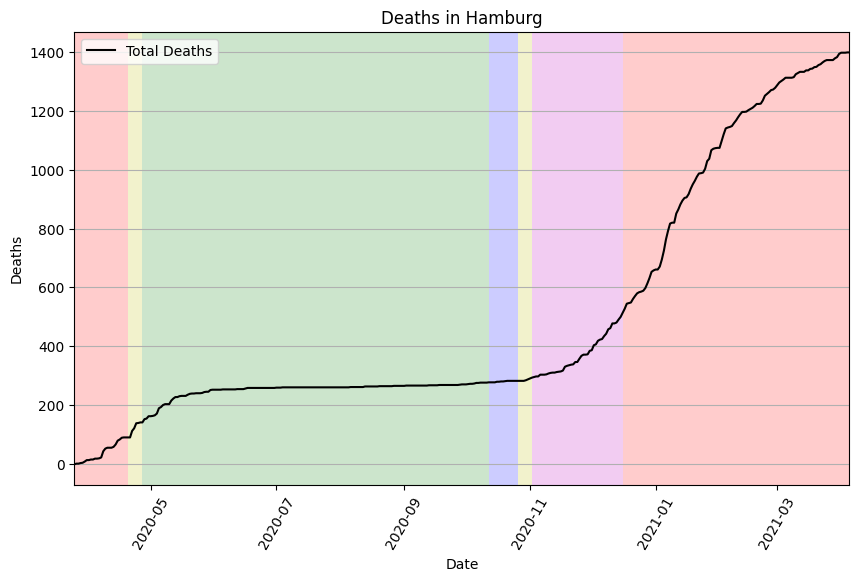

In [23]:
plt.figure()
plt.plot(total_deaths.index, total_deaths, "black", label="Total Deaths")
for i, (date, (text, color)) in enumerate(RESTRICTIONS.items()):
    plt.axvspan(date, list(RESTRICTIONS.keys())[i + 1] if i + 1 < len(RESTRICTIONS) else daily_cases_rolling7.index[-1], facecolor=color, alpha=0.2, zorder=-1)
plt.title("Deaths in Hamburg")
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.xticks(rotation=60)
plt.xlim(xmin=total_deaths.index[0], xmax=total_deaths.index[-1])
plt.grid(axis="y")
plt.show()

In [24]:
total_deaths.tail(8).T

date,2021-03-29,2021-03-30,2021-03-31,2021-04-01,2021-04-02,2021-04-03,2021-04-04,2021-04-05
deaths,1378,1382,1393,1397,1397,1397,1398,1398
